# Importamos y Cogemos Material Necesario

Librerías

In [13]:
import os
import zipfile
import tensorflow as tf
import keras
import gdown
import zipfile
import tensorflow as tf
import keras_preprocessing
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

Descargamos nuestro dataset de google drive a nuestra carpeta temporal "/tmp/vehdata"

In [14]:



url = 'https://drive.google.com/uc?id=1GWjZDtSnsCHLb-NqaMlvliM87DdciYtJ'
output = '/tmp/vehdata.zip'
gdown.download(url, output, quiet=False)





Downloading...
From: https://drive.google.com/uc?id=1GWjZDtSnsCHLb-NqaMlvliM87DdciYtJ
To: /tmp/vehdata.zip
100%|██████████| 1.30G/1.30G [00:46<00:00, 27.8MB/s]


'/tmp/vehdata.zip'

Creamos los directorios de nuestro conjunto de datos 

In [15]:


local_zip = '/tmp/vehdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/vehdata'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training pictures with no infants 
train_empty_dir = os.path.join(train_dir, 'empty')

# Directory with our training WITH infants in the car
train_infant_dir = os.path.join(train_dir, 'infant')

# Directory with our validation with no infants
validation_empty_dir = os.path.join(validation_dir, 'empty')

# Directory with our validation WITH infants in the car
validation_infant_dir = os.path.join(validation_dir, 'infant')

Utilizamos tecnicas de data aumentation, para crear mas imagenes que en teoria nos entrenara un mejor modelo 

In [16]:



TRAINING_DIR = "/tmp/vehdata/train/"
train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/vehdata/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Creamos el modelo de la red neuronal con 4 capaz convolucionales y una capa oculta

In [17]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')



])


Creamos a "callback" para parar el entrenamiento de nuestra red neuronal cuando alcanzemos un determinado valor de precision. 

In [18]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

Empezamos el entrenamiento de nuestra red neuronal 

In [19]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 30,
            epochs = 100,
            validation_steps = 2,
            verbose = 2,
            callbacks=[callbacks])
model.save("rps.h5")

Epoch 1/100


2022-10-30 20:00:46.681622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-30 20:01:02.749770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 - 18s - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - 18s/epoch - 598ms/step
Epoch 2/100
30/30 - 17s - loss: 0.6915 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.5000 - 17s/epoch - 564ms/step
Epoch 3/100
30/30 - 17s - loss: 0.6894 - accuracy: 0.5383 - val_loss: 0.6769 - val_accuracy: 0.6000 - 17s/epoch - 565ms/step
Epoch 4/100
30/30 - 17s - loss: 0.6882 - accuracy: 0.5750 - val_loss: 0.6409 - val_accuracy: 0.7750 - 17s/epoch - 560ms/step
Epoch 5/100
30/30 - 17s - loss: 0.6827 - accuracy: 0.5817 - val_loss: 0.6724 - val_accuracy: 0.6250 - 17s/epoch - 558ms/step
Epoch 6/100
30/30 - 17s - loss: 0.6862 - accuracy: 0.5933 - val_loss: 0.6480 - val_accuracy: 0.7500 - 17s/epoch - 558ms/step
Epoch 7/100
30/30 - 17s - loss: 0.6775 - accuracy: 0.6017 - val_loss: 0.6009 - val_accuracy: 0.8500 - 17s/epoch - 558ms/step
Epoch 8/100
30/30 - 17s - loss: 0.6706 - accuracy: 0.6367 - val_loss: 0.6740 - val_accuracy: 0.6750 - 17s/epoch - 557ms/step
Epoch 9/100


Una vez entrenada podemos observar como nuestra red se entreno. 

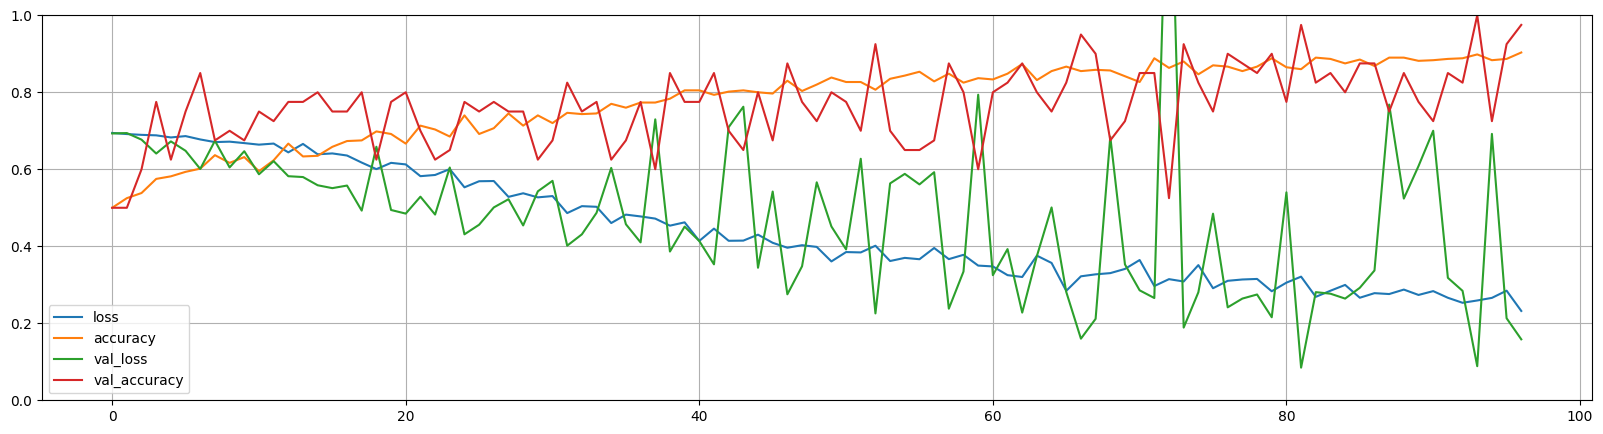

In [20]:


pd.DataFrame(history.history).plot(figsize=(20,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()